In [1]:
import pandas as pd
import json
import numpy as np
import nltk 
import string
import re
import os
import ast

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\72809\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\72809\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Load Json Data

In [3]:
# Read the entire file into a python array
with open('tweets.json', 'rb') as f:
    data = f.readlines()

In [4]:
# Show the attributes in a Tweet object
new_data = json.loads(data[0])
print(new_data)

{'_id': {'$oid': '5e6077325d8ebba864ce03e7'}, 'created_at': {'$date': '2020-03-05T03:51:09.000Z'}, 'id': {'$numberLong': '1235412509017989125'}, 'id_str': '1235412509017989125', 'text': 'RT @KingGeorge: Massive follower #Giveaway from myself + @CORSAIR. #Ad \n\nTo enter:\n🔗 Click here: https://t.co/9R4COF9yQF\n\nBonus entries:\n💬…', 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 3327978974, 'id_str': '3327978974', 'name': 'RJ', 'screen_name': 'rj101701', 'location': None, 'url': None, 'description': 'The hardest choices require the strongest wills-Thanos', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 22, 'friends_count': 458, 'listed_count': 0, 'favourites_count': 6411, 'statuses_count': 179, 'created_at

In [5]:
# All the keys in a Tweet Object
print(new_data.keys())

dict_keys(['_id', 'created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang', 'timestamp_ms'])


# 2. Extract Text and Hashtag

In [6]:
def GetTextAndHashtag(new_data):
    # Get hashtags in a Tweet Object
    ht = new_data['entities']['hashtags']
    ht_list = []
    for hat in ht:
        ht_list.append(hat['text'])

    # Get text in a Tweet Object
    text = new_data['text']
    return ht_list, text

# print(ht_list,'\n', text)

In [8]:
# Extract "text" and "hashtags" from Tweet Objects
total_ht = []
total_text = []
for dt in data:
    data_dict = json.loads(dt)
    ht_list,text = GetTextAndHashtag(data_dict)
    total_ht.append(ht_list)
    total_text.append(text)

total_dict = {'text':total_text,
             'hashtags':total_ht}
df = pd.DataFrame(total_dict)
df

,text,hashtags
0,RT @KingGeorge: Massive follower #Giveaway fro...,"[Giveaway, Ad]"
1,RT @Stray_Kids: [BuzzFeed]\nStray Kids(스트레이 키즈...,"[StrayKids, 스트레이키즈]"
2,Opportunities for Clinical Manager (RN) in Pan...,"[Panama, CTNA, LPN, Nurse, NursingJobs, Panama..."
3,RT @RecordingAcad: .@BTS_twt landed a No. 1 hi...,[ON]
4,RT @Bangalore_DFC: #Karnan Today @AnandaVikata...,[Karnan]
...,...,...
146222,Standing alone in an empty #chicago subway. @ ...,[chicago]
146223,So lucky to be spending more time with my favo...,"[sunshine, beachwalk]"
146224,"current weather in Rialto: scattered clouds, 5...",[]
146225,"current weather in La Verne: scattered clouds,...",[]


In [11]:
# Select the text with only one hashtag
oneht_idx = []
for idx in range(df.shape[0]):
    if len(df['hashtags'][idx]) != 1:
        oneht_idx.append(idx)
df_oneht = df.drop(oneht_idx)
df_oneht

,text,hashtags
3,RT @RecordingAcad: .@BTS_twt landed a No. 1 hi...,[ON]
4,RT @Bangalore_DFC: #Karnan Today @AnandaVikata...,[Karnan]
7,RT @Amandatammi: My favorite part of my Wednes...,[Chicagopd]
8,RT @Twins: A sight for sore eyes 😍 #MNTwins ht...,[MNTwins]
10,A new #superfan is enjoying what I've been po...,[superfan]
...,...,...
146200,Cameroon confirms first two coronavirus cases ...,[Nigeriatunes]
146204,Okay Drake! Back up 8 with 9:00 left. #ArchM...,[ArchMadness]
146212,📢 Important Update\nHRD Ministry orders to pos...,[COVID19]
146213,"#GODBlessAmerica 🇺🇸 !!! @ Houston, Texas https...",[GODBlessAmerica]


# 3. Preprocessing of Text and Hashtag

In [12]:
# Punctuation/Tickers/Hyperlinks removal
def remove_punct(text):
    text = re.sub(r'\$\w*','',text) # Remove tickers
    text = re.sub(r'https?:\/\/.*\/\w*','',text) # Remove hyperlinks
    text = re.sub(r'['+string.punctuation+']+', ' ',text) # Remove puncutations like 's
#     text  = "".join([char for char in str(text) if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

# Sub division of strings into arrays of words
def tokenization(text):
    text = re.split('\W+', text)
    return text

# Stop words removal 
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

# Getting the root/base of words
def stemming(text):
    ps = nltk.PorterStemmer()
    text = [ps.stem(word) for word in text]
    return text

# Linking similar words to one word
def lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    return text

# Text processing
def process_dataframe(data):
    df  = pd.DataFrame(data[['text']])
    df['text_punct'] = df['text'].apply(lambda x: remove_punct(x))
    df['text_tokenized'] = df['text_punct'].apply(lambda x: tokenization(x.lower()))
    df['text_nonstop'] = df['text_tokenized'].apply(lambda x: remove_stopwords(x))
    df['text_stemmed'] = df['text_nonstop'].apply(lambda x: stemming(x))
    df['text_lemmatized'] = df['text_nonstop'].apply(lambda x: lemmatizer(x))
    df = df.drop(columns=['text_punct', 'text_tokenized', 'text_nonstop', 'text_stemmed'])
    df = df.rename(columns={'text':'original_text', 'text_lemmatized':'processed_text'})
    return df

In [14]:
# Processing dataset
print('Pre-processing Text Data...')
processed_text = process_dataframe(df_oneht)
processed_text

Pre-processing Text Data...


,original_text,processed_text
3,RT @RecordingAcad: .@BTS_twt landed a No. 1 hi...,"[rt, recordingacad, bts, twt, landed, hit, bil..."
4,RT @Bangalore_DFC: #Karnan Today @AnandaVikata...,"[rt, bangalore, dfc, karnan, today, anandavika..."
7,RT @Amandatammi: My favorite part of my Wednes...,"[rt, amandatammi, favorite, part, wednesday, c..."
8,RT @Twins: A sight for sore eyes 😍 #MNTwins ht...,"[rt, twin, sight, sore, eye, mntwins, ]"
10,A new #superfan is enjoying what I've been po...,"[new, superfan, enjoying, posting, sneak, peek..."
...,...,...
146200,Cameroon confirms first two coronavirus cases ...,"[cameroon, confirms, first, two, coronavirus, ..."
146204,Okay Drake! Back up 8 with 9:00 left. #ArchM...,"[okay, drake, back, left, archmadness]"
146212,📢 Important Update\nHRD Ministry orders to pos...,"[, important, update, hrd, ministry, order, po..."
146213,"#GODBlessAmerica 🇺🇸 !!! @ Houston, Texas https...","[, godblessamerica, houston, texas, ]"


In [15]:
final_df = pd.DataFrame()
final_df['text'] = processed_text['processed_text']
final_df['hashtags'] = df_oneht['hashtags']
final_df

,text,hashtags
3,"[rt, recordingacad, bts, twt, landed, hit, bil...",[ON]
4,"[rt, bangalore, dfc, karnan, today, anandavika...",[Karnan]
7,"[rt, amandatammi, favorite, part, wednesday, c...",[Chicagopd]
8,"[rt, twin, sight, sore, eye, mntwins, ]",[MNTwins]
10,"[new, superfan, enjoying, posting, sneak, peek...",[superfan]
...,...,...
146200,"[cameroon, confirms, first, two, coronavirus, ...",[Nigeriatunes]
146204,"[okay, drake, back, left, archmadness]",[ArchMadness]
146212,"[, important, update, hrd, ministry, order, po...",[COVID19]
146213,"[, godblessamerica, houston, texas, ]",[GODBlessAmerica]


## 3.1 Display the distribution of hashtags

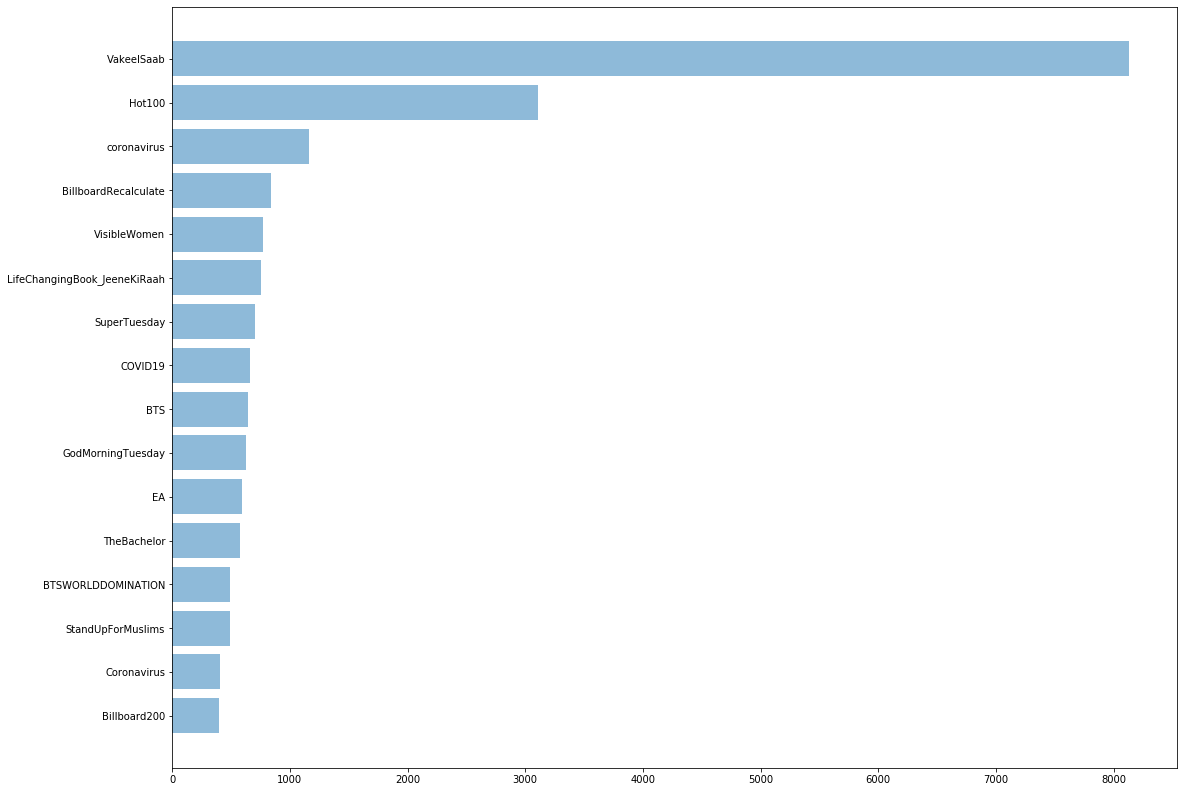

In [16]:
import matplotlib.pyplot as plt
from operator import itemgetter

# Count the # of each hashtag
hashtag_counts = {}
for hashtag in final_df["hashtags"]:
    if hashtag[0] in hashtag_counts:
        hashtag_counts[hashtag[0]] += 1
    else:
        hashtag_counts[hashtag[0]] = 1

# Show the top 16 hashtags
names = []
counts = []
count_list = [[k,v] for k,v in hashtag_counts.items()]
count_list = sorted(count_list, key=itemgetter(1),reverse=True)
[names.append(item[0]) for item in count_list[:16]]
[counts.append(item[1]) for item in count_list[:16]]

name_ticks = np.arange(0,len(names))+0.55

plt.figure(figsize=(18,14))
plt.barh(name_ticks, counts, align='center', alpha=0.5)
plt.yticks(name_ticks, names)
plt.gca().invert_yaxis()
plt.show()

## 3.2 Create Dataset

In [255]:
# Select tweets according to the similar hashtags 
ht_c1 = {'BillboardRecalculate','Billboard200','BTS', 'BTSWORLDDOMINATION'}
ht_c2 = {'coronavirus', 'COVID19', 'Coronavirus'}
# ht_c3 = {'SuperTuesday','GodMorningTuesday'}
# ht_c4 = {'VakeelSaab'}
c1_idx = []
c2_idx = []
# c3_idx = []
# c4_idx = []

for idx in final_df["hashtags"].index:
    if final_df["hashtags"][idx][0] in ht_c1:
        c1_idx.append(idx)
    if final_df["hashtags"][idx][0] in ht_c2:
        c2_idx.append(idx)
#     if final_df["hashtags"][idx][0] in ht_c3:
#         c3_idx.append(idx)
#     if final_df["hashtags"][idx][0] in ht_c4:
#         c4_idx.append(idx)

print("# of Class 1:", len(c1_idx),"\n"
      "# of Class 2:", len(c2_idx),"\n")
#       "# of Class 3:", len(c3_idx),"\n")
#       "# of Class 4:", len(c4_idx))

# of Class 1: 2373 
# of Class 2: 2225 



In [256]:
# Select samples randomly from each class to make the dataset 
import random
random.seed()
new_c1_idx = random.sample(c1_idx,2000)
new_c2_idx = random.sample(c2_idx,2000)
# new_c3_idx = random.sample(c3_idx,1000)
# new_c4_idx = random.sample(c4_idx,1000)

dataset = pd.DataFrame()
dataset["Sample Index"] = new_c1_idx + new_c2_idx #+ new_c3_idx #+ new_c4_idx
dataset["Topic"] = np.ones(2000).tolist() + np.zeros(2000).tolist()
dataset = dataset.sample(frac=1)
dataset

,Sample Index,Topic
1132,20746,1.0
2577,24595,0.0
1438,6857,1.0
2310,63420,0.0
1882,2526,1.0
...,...,...
2552,142068,0.0
2791,120371,0.0
3038,15292,0.0
2755,70177,0.0


## 3.3 Recombine the filtered tweets

In [257]:
cleaned_tweets  = []
for i in dataset["Sample Index"]:
    tt = final_df["text"][i]
    cleaned_tweet = " ".join(w for w in tt if len(w) > 2 and w.isalpha())
    cleaned_tweets.append(cleaned_tweet)
cleaned_tweets

['army eye bts twt btsworlddomination',
 'mel faith iranian flocking lick shrine holy object protect covid licking',
 'btschartdata brand new day btsworlddomination',
 'ajenglish china coronavirus lockdown unexpected side effect significant drop pollution level',
 'jimvbls king number bitch btsworlddomination',
 'popcrave bts top single pop act three congratulation bts twt',
 'upasanakonidela secunderabad hospitalsapollo detected case coronavirus due strict screening protocol patient currently',
 'btschartdata track outro ego btsworlddomination',
 'laurie garrett epidemic exceeded official case covid south korea italy iran',
 'nikki miumiu putting pregnant nurse frontline combat coronavirus became inspiring news prc state medium number',
 'chart bts map soul debuted top major music market world official chart',
 'globaltimesnews chengdu city sichuan province armed covid epidemic control personnel high tech smart helmet',
 'billboard try get vietnamese coronavirus psa song head',
 'pink

# 4. Apply TF-IDF & Kmeans to Cluster Tweets' Topic

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.cluster import KMeans

# Use TF-IDF to extract feature vectors
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,5))  
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_tweets)  
feature_names = tfidf_vectorizer.get_feature_names() # num phrases  

Can't find a reasonable of clusters according to silhouette score


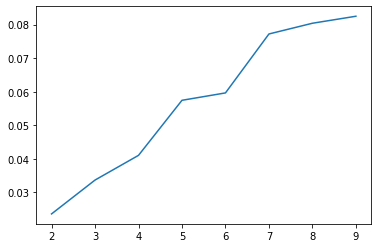

In [284]:
# Determine the best # of clusters by Silhouette Coefficient
from sklearn import metrics
SC = []
for num_clusters in range(2,10):
    km = KMeans(n_clusters=num_clusters)  
    km.fit(tfidf_matrix)
    SC.append(metrics.silhouette_score(tfidf_matrix,km.labels_))
plt.plot(range(2,10),SC)
print("Can't find a reasonable of clusters according to silhouette score")

In [277]:
# Use KMeans to cluster the feature vectors
num_clusters =2
km = KMeans(n_clusters=num_clusters)  
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()  
cluster_df = pd.DataFrame()
cluster_df['ClusterID'] = clusters  
print(cluster_df['ClusterID'].value_counts(),"\n")

# Display the results of the topic clustering based on TF-IDF
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    words = []
    for ind in order_centroids[i, :5]:
        words.append(feature_names[ind])
    print("Topic {} : Words {}:".format(i,words))

0    3431
1     569
Name: ClusterID, dtype: int64 

Topic 0 : Words ['coronavirus', 'billboardrecalculate', 'bts', 'btsworlddomination', 'covid']:
Topic 1 : Words ['billboard', 'bts', 'chart', 'barbiefobia', 'bts eternal']:


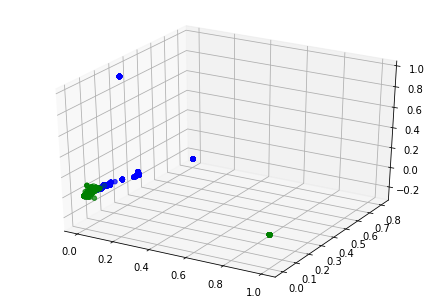

In [278]:
# Feature of TF-IDF (tfidf_matrix) is a huge sparse matrix, cannot use PCA to reduce dimensions
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
clf = TruncatedSVD(3)
Xpca = clf.fit_transform(tfidf_matrix)

Xpca_df = pd.DataFrame()
Xpca_df["X"] = Xpca[:,0]
Xpca_df["Y"] = Xpca[:,1]
Xpca_df["Z"] = Xpca[:,2]
Xpca_df["lables"] = km.labels_
Xpca0 = Xpca_df.loc[Xpca_df["lables"]==0]
Xpca1 = Xpca_df.loc[Xpca_df["lables"]==1]
# Xpca2 = Xpca_df.loc[Xpca_df["lables"]==2]
# Xpca3 = Xpca_df.loc[Xpca_df["lables"]==3]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xpca0["X"],Xpca0["Y"],Xpca0["Z"],marker='o', c='g')
ax.scatter(Xpca1["X"],Xpca1["Y"],Xpca1["Z"],marker='o', c='b')
# ax.scatter(Xpca2["X"],Xpca2["Y"],Xpca2["Z"],marker='o', c='r')
# ax.scatter(Xpca3["X"],Xpca3["Y"],Xpca3["Z"],marker='o', c='k')

# 5. Apply Doc2Vec & Kmeans to Cluster Tweets' Topic

In [271]:
import gensim
from gensim.models.doc2vec import TaggedDocument
taggeddocs = []
tag2tweetmap = {}
for index,i in enumerate(cleaned_tweets):
    if len(i) > 2: # Non empty tweets
        tag = u'SENT_{:d}'.format(index)
        sentence = TaggedDocument(words=gensim.utils.to_unicode(i).split(), tags=[tag])
        tag2tweetmap[tag] = i
        taggeddocs.append(sentence)
        

model = gensim.models.Doc2Vec(taggeddocs, dm=0, alpha=0.001, vector_size=50)
for epoch in range(100):
    if epoch % 10 == 0:
        print('Now training epoch %s' % epoch)
    model.train(taggeddocs, total_examples=model.corpus_count, epochs=model.iter)
#     model.alpha -= 0.002  # decrease the learning rate
#     model.min_alpha = model.alpha  # fix the learning rate, no decay

Now training epoch 0


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 10


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 20


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 30


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 40


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 50


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 60


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 70


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 80


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

Now training epoch 90


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
C:\Users\72809\miniconda3\envs\EE260\lib\site-pack

C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


The best silhouette score is: 0.4933575


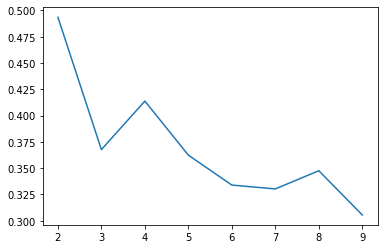

In [283]:
dataSet = model.docvecs.doctag_syn0
# Determine the best # of clusters of KMeans by Silhouette Coefficient
from sklearn import metrics
SC = []
for num_clusters in range(2,10):
    km = KMeans(n_clusters=num_clusters)  
    km.fit(dataSet)
    SC.append(metrics.silhouette_score(dataSet,km.labels_))
plt.plot(range(2,10),SC)
print("The best silhouette score is:", SC[0])

In [276]:
km = KMeans(n_clusters=2)
centroidIndx = km.fit_predict(dataSet)  
cluster_df = pd.DataFrame()
cluster_df['ClusterID'] = centroidIndx  
print(cluster_df['ClusterID'].value_counts(),"\n")
topic2wordsmap = {}
for i, val in enumerate(dataSet):
    tag = model.docvecs.index_to_doctag(i)
    topic = centroidIndx[i]
    if topic in topic2wordsmap.keys():
        for w in (tag2tweetmap[tag].split()):
            topic2wordsmap[topic].append(w)
    else:
        topic2wordsmap[topic] = []
for i in topic2wordsmap:
    words = topic2wordsmap[i]
    print("Topic {} has words {}".format(i, words[:5]))

1    2743
0    1256
Name: ClusterID, dtype: int64 

Topic 0 has words ['btschartdata', 'brand', 'new', 'day', 'btsworlddomination']
Topic 1 has words ['ajenglish', 'china', 'coronavirus', 'lockdown', 'unexpected']


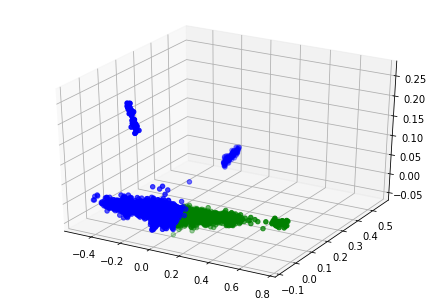

In [279]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
pca.fit(dataSet)
Xpca_df = pd.DataFrame()
Xpca = pca.transform(dataSet)
Xpca_df["X"] = Xpca[:,0]
Xpca_df["Y"] = Xpca[:,1]
Xpca_df["Z"] = Xpca[:,2]
Xpca_df["lables"] = centroidIndx
Xpca0 = Xpca_df.loc[Xpca_df["lables"]==0]
Xpca1 = Xpca_df.loc[Xpca_df["lables"]==1]
# Xpca2 = Xpca_df.loc[Xpca_df["lables"]==2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xpca0["X"],Xpca0["Y"],Xpca0["Z"],marker='o', c='g')
ax.scatter(Xpca1["X"],Xpca1["Y"],Xpca1["Z"],marker='o', c='b')
# ax.scatter(Xpca2["X"],Xpca2["Y"],Xpca2["Z"],marker='o', c='r')

# 6. Apply LDA to Cluster Tweets' Topic

In [280]:
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

texts = [text for text in cleaned_tweets if len(text) > 2]
doc_clean = [clean(doc).split() for doc in texts]
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
ldamodel = models.ldamodel.LdaModel(doc_term_matrix, num_topics=2, id2word = dictionary, passes=10)

for topic in ldamodel.show_topics(num_topics=3, formatted=False, num_words=10):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['bts', 'billboard', 'billboardrecalculate', 'twt', 'btsworlddomination', 'chart', 'map', 'soul', 'billboardcharts', 'album']
Topic 1: Words: 
['coronavirus', 'covid', 'case', 'people', 'new', 'back', 'emergency', 'fight', 'long', 'trying']


In [281]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
print(cm.get_coherence())

0.35451789742110423


In [282]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.215793  0.0       1        1  53.335987
0     -0.215793  0.0       2        1  46.664009, topic_info=                     Term         Freq        Total Category  logprob  loglift
1                     bts  1233.000000  1233.000000  Default  30.0000  30.0000
98              billboard   696.000000   696.000000  Default  29.0000  29.0000
22            coronavirus  1299.000000  1299.000000  Default  28.0000  28.0000
122  billboardrecalculate   626.000000   626.000000  Default  27.0000  27.0000
5                   covid   575.000000   575.000000  Default  26.0000  26.0000
..                    ...          ...          ...      ...      ...      ...
232                  make    76.443848    83.244667   Topic2  -5.4859   0.6770
140                  http    96.043678   139.974762   Topic2  -5.2576   0.3855
34                 number   101.950859   164.616196   Topic2  -5.1980   0.2831
19                    new    78.609207   194.280075   Topic2  -5.4580  -0.1426
22            coronavirus    83.541039  1299.431885   Topic2  -5.3971  -1.9821

[114 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
182       2  0.998453  album
136       1  0.956328    amp
136       2  0.042036    amp
0         1  0.007256   army
0         2  0.994097   army
...     ...       ...    ...
4         2  0.996938    twt
376       1  0.055774   week
376       2  0.941962   week
85        1  0.008245  world
85        2  0.989430  world

[118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])